In [2]:
from spectrae import Spectra, SpectraDataset
from torchdrug import datasets
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from tqdm import tqdm
from gears.pertdata import PertData
from gears.gears import GEARS


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


# SPECTRA Single Cell Perturbation Tutorial

### We take an example norman single-cell perturbation dataset from GEARS, taking the mean logfold change for each perturbation
### We define a continuous spectral property based on a l2 norm between two perturbation expression vectors. We return the negative of this value since the algorithm expects a larger value means more similar.
### We define cross-split overlap as average l2 norm between perturbation expression vectors in the test versus the train

In [2]:
class SC_Perturb_Dataset(SpectraDataset):
    
    def parse(self, input_file):
        pert_data = PertData('./data')
        pert_data.load(data_name = input_file)
        self.adata = pert_data.adata
        self.control_expression = self.adata[self.adata.obs['condition'] == 'ctrl'].X.toarray().mean(axis=0)
        return [p for p in self.adata.obs['condition'].unique() if p != 'ctrl']

    def __len__(self):
        return len(self.samples)

    def get_mean_logfold_change(self, perturbation):
        perturbation_expression = self.adata[self.adata.obs['condition'] == perturbation].X.toarray().mean(axis=0)
        logfold_change = np.nan_to_num(np.log2(perturbation_expression + 1) - np.log2(self.control_expression + 1))
        return logfold_change
    
    def sample_to_index(self, sample):
        if not hasattr(self, 'index_to_sequence'):
            print("Generating index to sequence")
            self.index_to_sequence = {}
            for i in tqdm(range(len(self))):
                x = self.__getitem__(i)
                self.index_to_sequence['-'.join(list(x))] = i

        return self.index_to_sequence[sample]            

    def __getitem__(self, idx):
        perturbation = self.samples[idx]
        return self.get_mean_logfold_change(perturbation)

In [3]:
class SPECTRA_SC_Perturb(Spectra):

    def spectra_properties(self, sample_one, sample_two):
        return -np.linalg.norm(sample_one - sample_two)

    def cross_split_overlap(self, train, test):
        average_similarity = []

        for i in test:
            for j in train:
                average_similarity.append(self.spectra_properties(i, j))

        return np.mean(average_similarity)

In [4]:
SC_Perturb_Dataset = SC_Perturb_Dataset('norman', 'norman')

Found local copy...
Found local copy...
Found local copy...
These perturbations are not in the GO graph and their perturbation can thus not be predicted
['RHOXF2BB+ctrl' 'LYL1+IER5L' 'ctrl+IER5L' 'KIAA1804+ctrl' 'IER5L+ctrl'
 'RHOXF2BB+ZBTB25' 'RHOXF2BB+SET']
Local copy of pyg dataset is detected. Loading...
Done!


In [5]:
sc_spectra = SPECTRA_SC_Perturb(SC_Perturb_Dataset, binary = False)

In [6]:
sc_spectra.pre_calculate_spectra_properties('sc_norman')

File sc_norman_precalculated_spectra_properties already exists, set force_recalculate to True to recalculate


In [7]:
spectra_parameters = {'number_repeats': 3, 
                      'random_seed': [42, 44, 46],
                      'spectral_parameters': ["{:.2f}".format(i) for i in np.arange(0, 1.05, 0.05)],
                      'force_reconstruct': True,
                                              }

sc_spectra.generate_spectra_splits(**spectra_parameters)

100%|██████████| 37950/37950 [00:00<00:00, 363134.50it/s]

Stats for SPECTRA property graph (SPG)
Number of nodes: 276
Number of edges: 37950
Number of connected components: 1




Generating SPECTRA split for spectral parameter 0.0 and dataset norman
Number of samples in independent set: 276
Train size: 220	Test size: 56
Cross split overlap: -4.8159260749816895



Generating SPECTRA split for spectral parameter 0.0 and dataset norman
Number of samples in independent set: 276
Train size: 220	Test size: 56
Cross split overlap: -4.60251522064209



Generating SPECTRA split for spectral parameter 0.0 and dataset norman
Number of samples in independent set: 276
Train size: 220	Test size: 56
Cross split overlap: -4.512292861938477



Generating SPECTRA split for spectral parameter 0.05 and dataset norman
Number of samples in independent set: 226
Train size: 180	Test size: 46
Cross split overlap: -4.9465131759643555



Generating SPECTRA split for spectral parameter 0.05 and dataset norman
Number of samples in independent set: 233
Train size: 186	Test size: 47
Cross split overlap: -4.982058048248291



Generating SPECTRA split for spectral parameter 0.05 and dataset no

[]

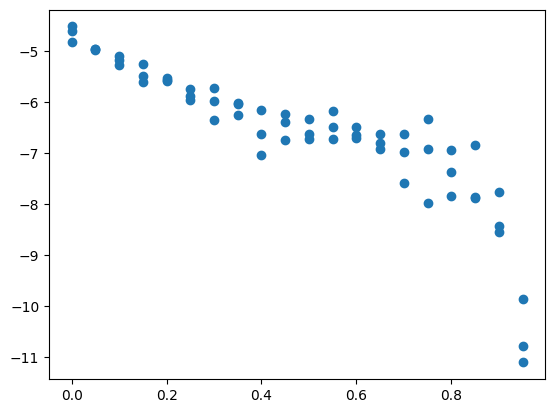

In [8]:
stats = sc_spectra.return_all_split_stats()
plt.scatter(stats['SPECTRA_parameter'], stats['cross_split_overlap'])

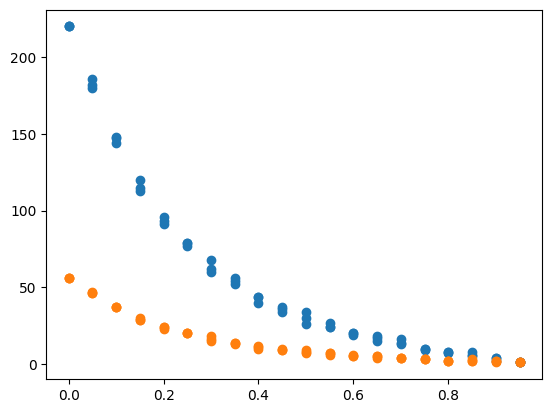

In [9]:
plt.scatter(stats['SPECTRA_parameter'], stats['train_size'])
plt.scatter(stats['SPECTRA_parameter'], stats['test_size']) 